In [1]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

In [2]:
torch.cuda.set_device(1)

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [3]:
user,item,title = 'userId','movieId','title'

In [4]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/jupyter/.fastai/data/movie_lens_sample')

In [5]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [6]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [7]:
y_range = [0,5.5]

In [8]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [10]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss
1,1.607942,0.907101
2,0.838588,0.663682
3,0.642996,0.660633


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [14]:
path=Path('~/.fastai/data/ml-100k/')

In [15]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
len(ratings)

100000

In [18]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [19]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title)

In [20]:
data.show_batch()

userId,title,target
301,Supercop (1992),5.0
348,Scream (1996),5.0
187,Harold and Maude (1971),4.0
39,Spice World (1997),5.0
387,"American Werewolf in London, An (1981)",4.0


In [21]:
y_range = [0,5.5]

In [22]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


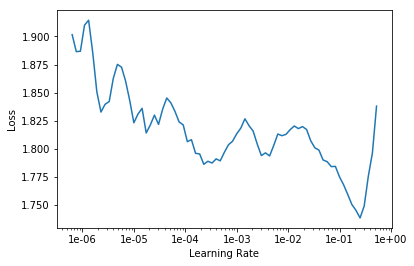

In [23]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [24]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,0.937967,0.934878
2,0.873477,0.883213
3,0.774156,0.844244
4,0.644226,0.816461
5,0.560959,0.814851


In [25]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [26]:
learn.load('dotprod');

In [27]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [28]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [29]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [30]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [31]:
item0 = lambda o:o[0]

In [32]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3507),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3002),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2903), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2758), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2642), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2611), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2512), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2387), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2376), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2181), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2176), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2166), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2148), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2075), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.1935), 'Sgt. Bilko (

In [33]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6082), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5934), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5600), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5510), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5364), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5247), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5215), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5208), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5175), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4880), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4879), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4795), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4753), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4693), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4617), 'Godfather, The (1972)', 4.283292978208232)]

### Movie weights

In [34]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [35]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [36]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [37]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1447), 'Close Shave, A (1995)'),
 (tensor(1.0784), 'Chinatown (1974)'),
 (tensor(1.0739), 'Casablanca (1942)'),
 (tensor(1.0554), 'Wrong Trousers, The (1993)'),
 (tensor(1.0203), 'Citizen Kane (1941)'),
 (tensor(0.9996), 'When We Were Kings (1996)'),
 (tensor(0.9927), 'Lawrence of Arabia (1962)'),
 (tensor(0.9796), 'Fargo (1996)'),
 (tensor(0.9772), 'Ran (1985)'),
 (tensor(0.9549), '12 Angry Men (1957)')]

In [38]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2992), 'Jungle2Jungle (1997)'),
 (tensor(-1.2494), 'Congo (1995)'),
 (tensor(-1.2422), 'Home Alone 3 (1997)'),
 (tensor(-1.2339), "McHale's Navy (1997)"),
 (tensor(-1.1842), 'Leave It to Beaver (1997)'),
 (tensor(-1.1459), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1441), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.1331), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1296), 'Bio-Dome (1996)'),
 (tensor(-1.0471), 'Batman & Robin (1997)')]

In [39]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [40]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1301), 'Braveheart (1995)'),
 (tensor(1.0089), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0046), 'Titanic (1997)'),
 (tensor(0.9059), 'Forrest Gump (1994)'),
 (tensor(0.8891), "It's a Wonderful Life (1946)"),
 (tensor(0.8574), 'Independence Day (ID4) (1996)'),
 (tensor(0.8360), 'American President, The (1995)'),
 (tensor(0.8339), 'Sleepless in Seattle (1993)'),
 (tensor(0.8280), 'Pretty Woman (1990)'),
 (tensor(0.8229), 'Field of Dreams (1989)')]

In [41]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8455), 'Trainspotting (1996)'),
 (tensor(-0.8105), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7899), 'Stupids, The (1996)'),
 (tensor(-0.7872), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7509), 'Keys to Tulsa (1997)'),
 (tensor(-0.7485), 'Dead Man (1995)'),
 (tensor(-0.7474), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.7296), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.7258), 'Very Brady Sequel, A (1996)'),
 (tensor(-0.7126), 'Serial Mom (1994)')]

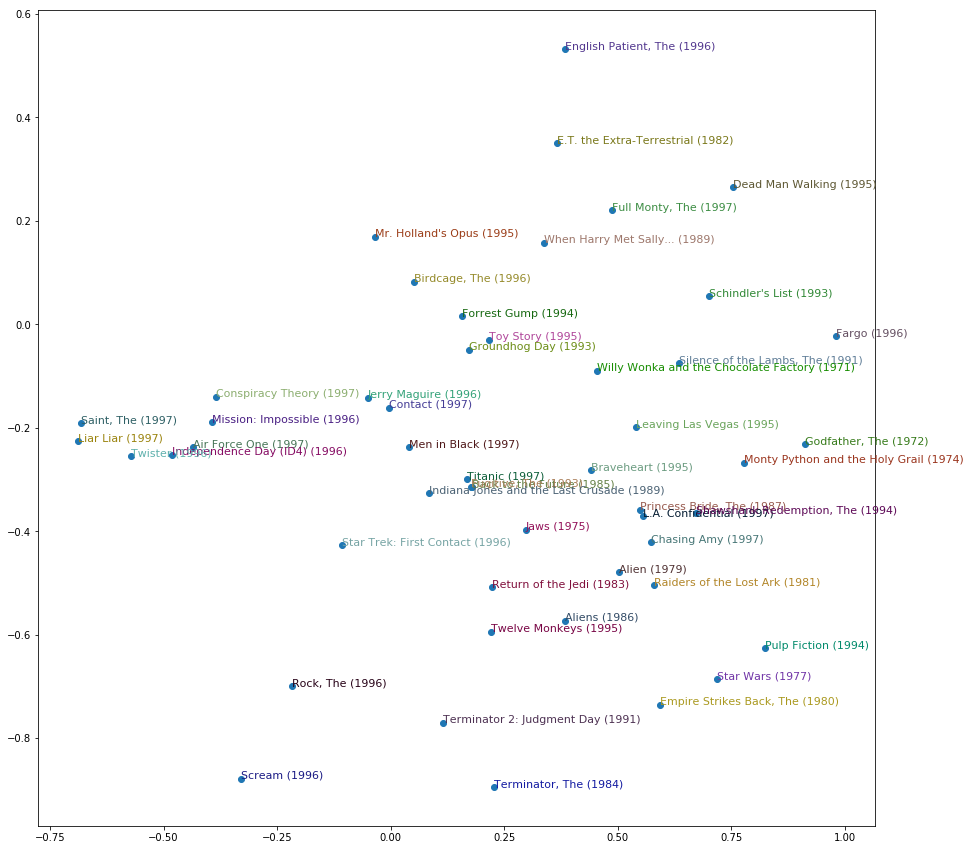

In [42]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()